In [16]:
import pandas as pd
import numpy as np
import scipy as sp
from datetime import datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split

chemin_fichier = '/Users/lucaslascaux/Desktop/docs trading/dataset.csv'

data = pd.read_csv(chemin_fichier)

data = data.assign(extended_returns_1=data['extended_returns'].shift(1),
                   extended_returns_2=data['extended_returns'].shift(2),
                   extended_returns_3=data['extended_returns'].shift(3),
                   extended_returns_4=data['extended_returns'].shift(4),
                   extended_returns_5=data['extended_returns'].shift(5))
data = data.dropna()
data.drop("symbol", axis=1, inplace=True)



data['extended_returns'] = data['extended_returns'].abs()  


In [17]:
data_extended_returns = data['extended_returns']

/var/folders/53/30dg38js7lb887sbxnyyv7b00000gn/T/ipykernel_31313/4204178108.py:17: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  ax1.stem(range(1, len(acf_values)), acf_values[1:], use_line_collection=True)
/var/folders/53/30dg38js7lb887sbxnyyv7b00000gn/T/ipykernel_31313/4204178108.py:24: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  ax2.stem(range(1, len(pacf_values)), pacf_values[1:], use_line_collection=True)


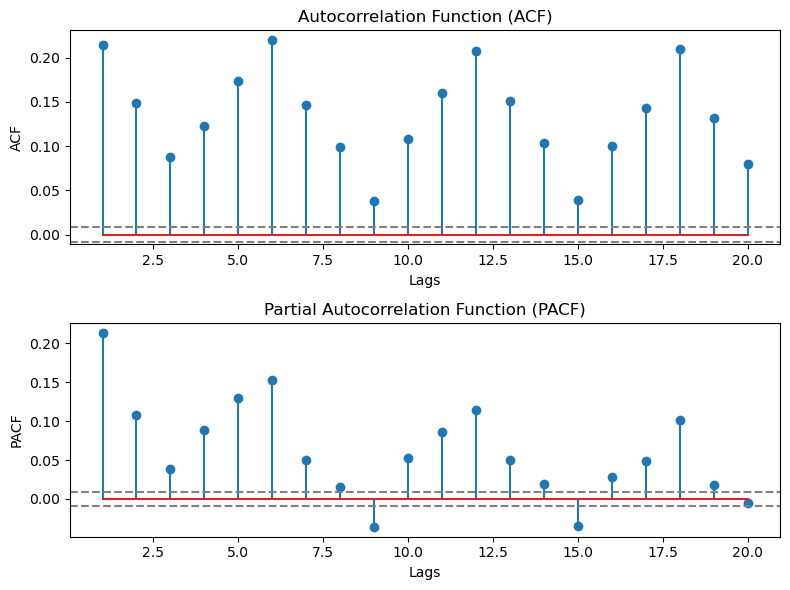

Ordre p identifié : 1
Ordre q identifié : 1


In [18]:
def ACF_PACF(data, max_lags):
    column = data['extended_returns']
    
    acf_values = acf(column, nlags=max_lags)
    pacf_values = pacf(column, nlags=max_lags)
    
    p = np.argmax(np.abs(acf_values[1:]) > 1.96/np.sqrt(len(column))) + 1
    
    q = np.argmax(np.abs(pacf_values[1:]) > 1.96/np.sqrt(len(column))) + 1
    
    # graphiques 
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
    ax1.stem(range(1, len(acf_values)), acf_values[1:], use_line_collection=True)
    ax1.axhline(y=1.96/np.sqrt(len(column)), linestyle='--', color='gray')
    ax1.axhline(y=-1.96/np.sqrt(len(column)), linestyle='--', color='gray')
    ax1.set_xlabel('Lags')
    ax1.set_ylabel('ACF')
    ax1.set_title('Autocorrelation Function (ACF)')
    
    ax2.stem(range(1, len(pacf_values)), pacf_values[1:], use_line_collection=True)
    ax2.axhline(y=1.96/np.sqrt(len(column)), linestyle='--', color='gray')
    ax2.axhline(y=-1.96/np.sqrt(len(column)), linestyle='--', color='gray')
    ax2.set_xlabel('Lags')
    ax2.set_ylabel('PACF')
    ax2.set_title('Partial Autocorrelation Function (PACF)')
    
    plt.tight_layout()
    plt.show()
    
    return p, q


p, q = ACF_PACF(data, max_lags=20)
print(f"Ordre p identifié : {p}")
print(f"Ordre q identifié : {q}")


In [19]:
def test_stationarity(data):
    columns = ["volatility", "extended_returns"]
    
    for column in columns:
        # test de stationnarité
        selected_column = data[column]
        
        # test de Dickey-Fuller augmenté (ADF test)
        result = adfuller(selected_column)
        
       
        print(f"Résultats du test de Dickey-Fuller augmenté pour la colonne '{column}':")
        print(f"Statistique du test : {result[0]}")
        print(f"Valeur p : {result[1]}")
        print("Valeurs critiques :")
        for key, value in result[4].items():
            print(f"   {key}: {value}")
        
        # stationnarité
        if result[1] < 0.05:
            print("Les données sont stationnaires.")
        else:
            print("Les données ne sont pas stationnaires.")
        print("\n")

In [20]:
test_stationarity(data)

Résultats du test de Dickey-Fuller augmenté pour la colonne 'volatility':
Statistique du test : -14.884218538537944
Valeur p : 1.592514085191503e-27
Valeurs critiques :
   1%: -3.4304866612504394
   5%: -2.8616004014063234
   10%: -2.5668021496813282
Les données sont stationnaires.


Résultats du test de Dickey-Fuller augmenté pour la colonne 'extended_returns':
Statistique du test : -15.576938903564775
Valeur p : 1.9544817485320233e-28
Valeurs critiques :
   1%: -3.4304866583944906
   5%: -2.861600400144083
   10%: -2.566802149009474
Les données sont stationnaires.




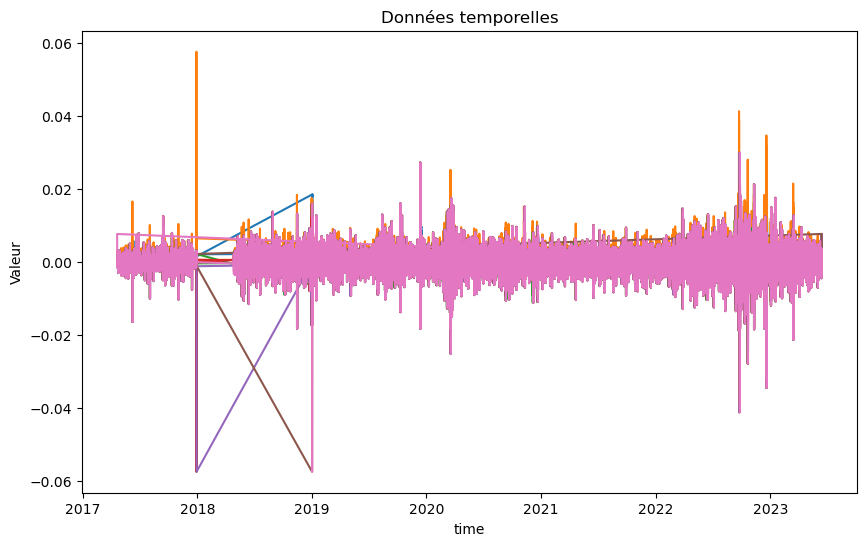

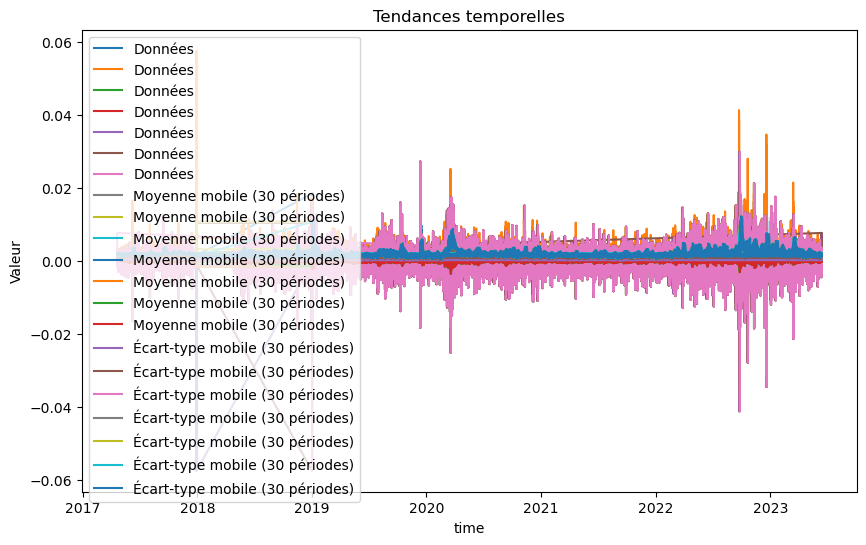

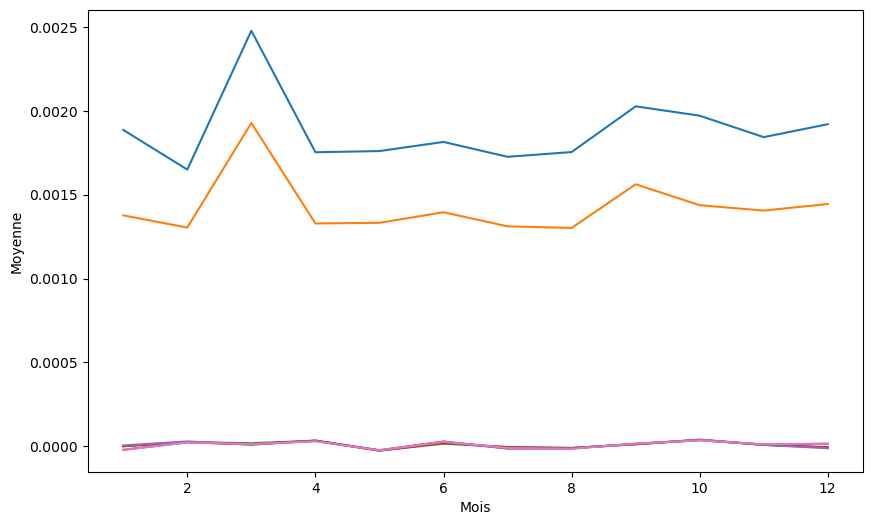

In [21]:
data['time'] = pd.to_datetime(data['time'])


data.set_index('time', inplace=True)

# Visualiser les données temporelles
plt.figure(figsize=(10, 6))
plt.plot(data)
plt.xlabel('time')
plt.ylabel('Valeur')
plt.title('Données temporelles')
plt.show()

# tendances temporelles
rolling_mean = data.rolling(window=30).mean()  # Moyenne mobile 30 périodes
rolling_std = data.rolling(window=30).std()  # Écart-type mobile 30 périodes

plt.figure(figsize=(10, 6))
plt.plot(data, label='Données')
plt.plot(rolling_mean, label='Moyenne mobile (30 périodes)')
plt.plot(rolling_std, label='Écart-type mobile (30 périodes)')
plt.xlabel('time')
plt.ylabel('Valeur')
plt.title('Tendances temporelles')
plt.legend()
plt.show()

# saisonnalité
monthly_mean = data.groupby(data.index.month).mean()  # Moyenne des valeurs par mois

plt.figure(figsize=(10, 6))
plt.plot(monthly_mean)
plt.xlabel('Mois')
plt.ylabel('Moyenne')

plt.show()

In [22]:
# Grid search pour sélectionner les ordres AR et MA
best_aic = float("inf")
best_order = None


p_max = 3
d = 1
q_max = 3

for p in range(p_max + 1):
    for q in range(q_max + 1):
        try:
            # Créez le modèle ARIMA avec les ordres actuels
            model = sm.tsa.ARIMA(data_extended_returns, order=(p, d, q))
            results = model.fit()

            # Calculez l'AIC et le BIC
            aic = results.aic
            bic = results.bic

            # Mettez à jour les meilleurs ordres si l'AIC est plus bas
            if aic < best_aic:
                best_aic = aic
                best_order = (p, d, q)

        except:
            continue

print("Meilleurs ordres ARIMA (p, d, q) :", best_order)
print("AIC correspondant :", best_aic)

/Users/lucaslascaux/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/lucaslascaux/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/lucaslascaux/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/lucaslascaux/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/lucaslascaux/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: Val

Meilleurs ordres ARIMA (p, d, q) : (1, 1, 3)
AIC correspondant : -482314.15436985705


In [23]:
p = 2
d = 1
q = 3


order = (p, d, q)


model = sm.tsa.ARIMA(data_extended_returns, order=order)

# 'css''
results = model.fit()


print("Paramètres estimés :", results.params)

/Users/lucaslascaux/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/lucaslascaux/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/lucaslascaux/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Paramètres estimés : ar.L1     0.385091
ar.L2    -0.767565
ma.L1    -1.192029
ma.L2     1.022658
ma.L3    -0.674616
sigma2    0.000002
dtype: float64


In [24]:

train_data, test_data = train_test_split(data_extended_returns, test_size=0.2, shuffle=False)

order = (p, d, q)


model = sm.tsa.ARIMA(train_data, order=order)


results = model.fit()


predictions = results.get_prediction(start=test_data.index[0], end=test_data.index[-1])
predicted_values = predictions.predicted_mean

mse = np.mean((predicted_values - test_data) ** 2)
rmse = np.sqrt(mse)
print("RMSE (Root Mean Squared Error) sur l'ensemble de test :", rmse)

/Users/lucaslascaux/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/lucaslascaux/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/lucaslascaux/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/lucaslascaux/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lucaslascaux/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/t

RMSE (Root Mean Squared Error) sur l'ensemble de test : 0.001616246443250795


In [25]:
# Forecast 3 prochaines périodes
order = (p, d, q)


model = sm.tsa.ARIMA(data_extended_returns, order=order)

results = model.fit()


forecast = results.get_forecast(steps=3)  


predicted_values = forecast.predicted_mean


for i, val in enumerate(predicted_values):
    print("Prédiction pour la période", i+1, ":")
    print("Valeur prédite :", val)
    print()


/Users/lucaslascaux/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/lucaslascaux/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/lucaslascaux/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Prédiction pour la période 1 :
Valeur prédite : 0.0017338299697416105

Prédiction pour la période 2 :
Valeur prédite : 0.0017790689018620184

Prédiction pour la période 3 :
Valeur prédite : 0.0015192807243787484



/Users/lucaslascaux/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
